This Colab script is based on Keith Bloemer's article: https://towardsdatascience.com/neural-networks-for-real-time-audio-stateless-lstm-97ecd1e590b8 et réutilise une partie de ces fonctions.

* If you want to train the model on the same effect as the one present in this colab, you just have to reuse the dataset present in Gitub and not change anything in the code. The model will be saved with the name you specify below (***'model_file_name'***).

* Otherwise, you can decide to use another database. For that, nothing very complicated, you just have to record a guitar part of at least 4min. (WARNING : The sampling frequency chosen here is 44100Hz, if you use a different one you will have to change it in the arguments of the ***'save_wav'*** function)

  Then, you will have to change the path of the audio (in the part ***'Load and Preprocess Data'***):
  *   audio_path 
  *   in_audio
  *   out_audio


**NB:** The longer the recording and the more varied the style of playing is, the better the model will be.

In [ ]:
## Not necessary for this part of the work. It will function with every version of tensorflow and keras. 
## However, it is necessary if you want to implement it on STM32
!pip install q tensorflow==2.0.0
!pip install q keras==2.3.1

In [ ]:
import tensorflow as tf
import os
from scipy import signal
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras.utils import Sequence

In [ ]:
def normalize(data):
    data_max = max(data)
    data_min = min(data)
    data_norm = max(data_max,abs(data_min))
    return data / data_norm

In [ ]:
class WindowArray(Sequence):
        
    def __init__(self, x, y, window_len, batch_size=32):
        self.x = x
        self.y = y[window_len-1:] 
        self.window_len = window_len
        self.batch_size = batch_size
        
    def __len__(self):
        return (len(self.x) - self.window_len +1) // self.batch_size
    
    def __getitem__(self, index):
        x_out = np.stack([self.x[idx: idx+self.window_len] for idx in range(index*self.batch_size, (index+1)*self.batch_size)])
        y_out = self.y[index*self.batch_size:(index+1)*self.batch_size]
        return x_out, y_out

In [ ]:
## Training Parameters
learning_rate = 0.001
hidden_units = 24

input_size = 120

batch_size = 4096
test_size = 0.2

### Load and Preprocess Data

In [ ]:
## You need to change the path with your audio_path
audio_path = '/content/drive/MyDrive/Colab Notebooks/3A/ToneCrafter/Test LSTM'
os.chdir(audio_path)

In [ ]:
## In this section, this is the loading and the Preprocess of the DATA:
## - Normalization between -1 and 1
## - Slicing the data in WindowArray Class

in_rate, in_data = wavfile.read(audio_path + '/ts9_test1_in_FP32.wav')
out_rate, out_data = wavfile.read(audio_path + '/ts9_test1_out_FP32.wav')


X_all = in_data.astype(np.float32).flatten()  
X_all = normalize(X_all).reshape(len(X_all),1)   
y_all = out_data.astype(np.float32).flatten() 
y_all = normalize(y_all).reshape(len(y_all),1)

In [ ]:
## Simply to test the model on a very different type of music
test_rate, test_data = wavfile.read(audio_path + '/[FREE] Acoustic Guitar Instrumental Beat 2019 #10.wav')
test_rate

In [ ]:
X_test = test_data.astype(np.float32).flatten()  
X_test = normalize(X_test).reshape(len(X_test),1)

y_test = test_data.astype(np.float32).flatten()  
y_test = normalize(y_test).reshape(len(y_test),1)   

### Extra code for different use case cut out here for brevity

In [ ]:
train_examples = int(len(X_all)*0.8)

train_arr = WindowArray(X_all[:train_examples], y_all[:train_examples], input_size, batch_size=batch_size)
val_arr = WindowArray(X_all[train_examples:], y_all[train_examples:], input_size, batch_size=batch_size)

### Create Sequential Model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv1D(4, 12, strides=12, activation=None, padding='same', input_shape=(input_size, 1)))
model.add(Conv1D(4, 12, strides=12, activation=None, padding='same'))

model.add(LSTM(hidden_units, input_shape=(input_size,1)))
model.add(Dense(1, activation=None))

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 4)             52        
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 4)              196       
                                                                 
 lstm (LSTM)                 (None, 24)                2784      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 3,057
Trainable params: 3,057
Non-trainable params: 0
_________________________________________________________________


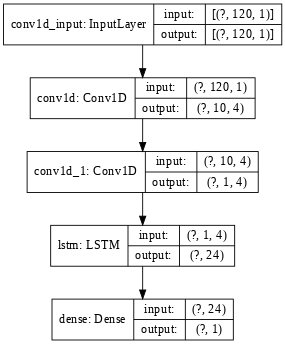

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

## Model Train

In [ ]:
history = model.fit(train_arr, 
                    validation_data=val_arr, 
                    epochs=50, 
                    shuffle=True,
                    verbose=2) 

Train for 1608 steps, validate for 402 steps
Epoch 1/50
1608/1608 - 46s - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 2/50
1608/1608 - 45s - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 3/50
1608/1608 - 45s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 4/50
1608/1608 - 46s - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 5/50
1608/1608 - 45s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 6/50
1608/1608 - 45s - loss: 0.0010 - mse: 0.0010 - val_loss: 8.6958e-04 - val_mse: 8.6958e-04
Epoch 7/50
1608/1608 - 45s - loss: 8.8975e-04 - mse: 8.8975e-04 - val_loss: 7.3857e-04 - val_mse: 7.3857e-04
Epoch 8/50
1608/1608 - 45s - loss: 8.1913e-04 - mse: 8.1913e-04 - val_loss: 6.9063e-04 - val_mse: 6.9063e-04
Epoch 9/50
1608/1608 - 45s - loss: 7.6960e-04 - mse: 7.6960e-04 - val_loss: 6.5090e-04 - val_mse: 6.5090e-04
Epoch 10/50
1608/1608 - 45s - loss: 7.2556e-04 - mse: 7.2556e-

### Verification of model training

Text(0.5, 1.0, 'Training and Validation Loss')

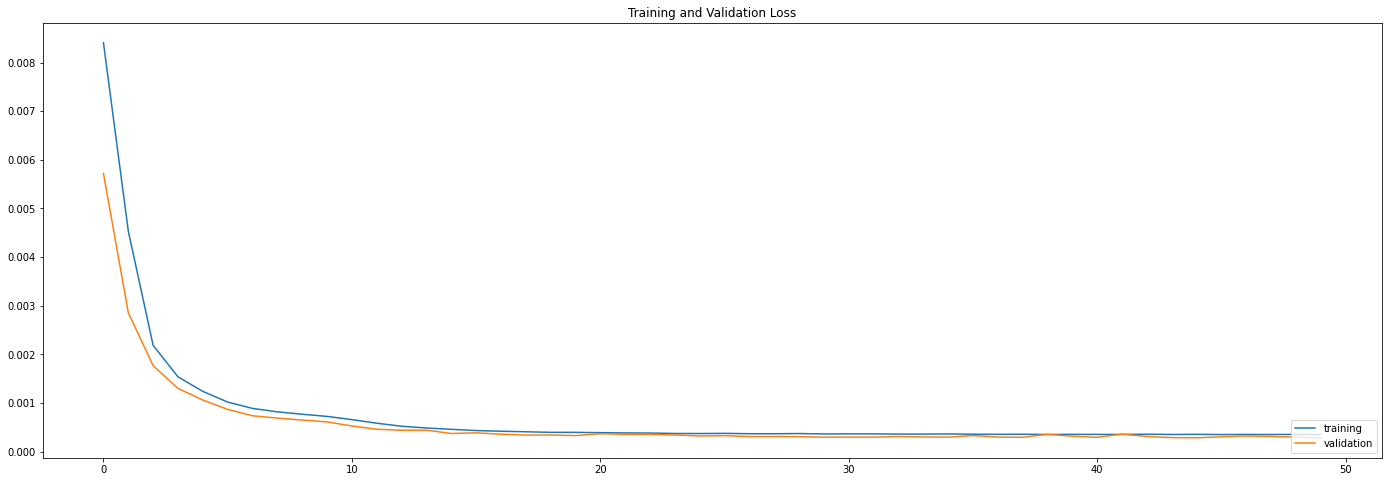

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.plot(epochs_range, loss, label="training")
plt.plot(epochs_range, val_loss, label="validation")
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [ ]:
#Save Keras model in .h5 format
model_file_name = 'ToneCrafter_50epochs'
model.save(model_file_name + '.h5')

## Prédiction

In [ ]:
model = tf.keras.models.load_model('ToneCrafter_50epochs.h5')

In [ ]:
def save_wav(name, data, sampling_freq):
    wavfile.write(name, sampling_freq, data.flatten().astype(np.float32))

In [ ]:
# Get the last 20% of the wav data to run prediction and plot results
y_the_rest, y_last_part = np.split(y_all, [int(len(y_all)*.8)])
x_the_rest, x_last_part = np.split(X_all, [int(len(X_all)*.8)])
y_test = y_last_part[input_size-1:] 
test_arr = WindowArray(x_last_part, y_last_part, input_size, batch_size = batch_size)

prediction = model.predict(test_arr)

save_wav(audio_path+'/y_pred_50epochs.wav', prediction, 44100)
save_wav(audio_path+'/x_test.wav', x_last_part, 44100)
save_wav(audio_path+'/y_test.wav', y_test, 44100)

### Prediction on a test sample

In [ ]:
# Pay attention to the sampling frequency of the test Audio ! You need to change it in the save_wave function if it is different from 44.1 kHz
# test_arr = WindowArray(X_test, y_test, input_size, batch_size = batch_size)
# prediction = model.predict(test_arr)

# save_wav(audio_path+'/test1.wav', prediction)

In [ ]:
# test = []
# a = 0
# for i in range(120):
#   test.append(a)
#   a = a + 0.1

# test = np.expand_dims(test, axis=1)
# test.shape

(120, 1)

In [ ]:
# test_pred = model.predict(test)
# test_pred.shape

## Visualization of results

### Temporal Verification

Plotting results..


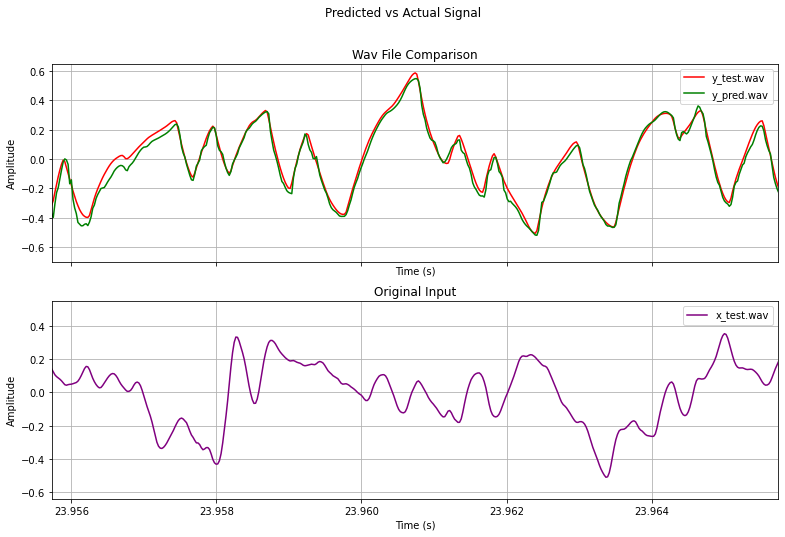

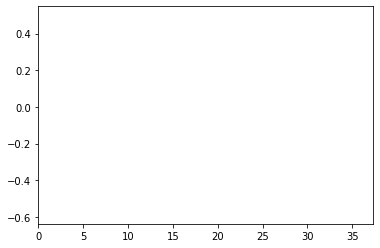

In [ ]:
def read_wave(wav_file):
    # Extract Audio and framerate from Wav File
    fs, signal = wavfile.read(wav_file)
    return signal, fs


def analyze_pred_vs_actual(output_wav, pred_wav, input_wav, model_name, show_plots, path):
    """Generate plots to analyze the predicted signal vs the actual
    signal.

    Inputs:
        output_wav : The actual signal, by default will use y_test.wav from the test.py output
        pred_wav : The predicted signal, by default will use y_pred.wav from the test.py output
        input_wav : The pre effect signal, by default will use x_test.wav from the test.py output
        model_name : Used to add the model name to the plot .png filename
        path   :   The save path for generated .png figures
        show_plots : Default is 1 to show plots, 0 to only generate .png files and suppress plots

    """

    # Read the input wav file
    signal3, fs3 = read_wave(input_wav)

    # Read the output wav file
    signal1, fs = read_wave(output_wav)

    Time = np.linspace(0, len(signal1) / fs, num=len(signal1))
    fig, (ax1, ax3) = plt.subplots(2, sharex=True, figsize=(13, 8))
    fig.suptitle("Predicted vs Actual Signal")
    ax1.plot(Time, signal1, label=output_wav, color="red")

    # Read the predicted wav file
    signal2, fs2 = read_wave(pred_wav)

    Time2 = np.linspace(0, len(signal2) / fs2, num=len(signal2))
    ax1.plot(Time2, signal2, label=pred_wav, color="green")
    ax1.legend(loc="upper right")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude")
    ax1.set_title("Wav File Comparison")
    ax1.grid("on")

    error_list = []
    for s1, s2 in zip(signal1, signal2):
        error_list.append(abs(s2 - s1))


    # Plot the original signal
    Time3 = np.linspace(0, len(signal3) / fs3, num=len(signal3))
    ax3.plot(Time3, signal3, label=input_wav, color="purple")
    ax3.legend(loc="upper right")
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Amplitude")
    ax3.set_title("Original Input")
    ax3.grid("on")

    # Save the plot
    plt.savefig(path+'/'+model_name + "_signal_comparison.png", bbox_inches="tight")
    # Create a zoomed in plot of 0.01 seconds centered at the max input signal value
    sig_temp = signal1.tolist()
    plt.axis(
        [
            Time3[sig_temp.index((max(sig_temp)))] - 0.005,
            Time3[sig_temp.index((max(sig_temp)))] + 0.005,
            min(signal2),
            max(signal2),
        ]
    )
   
    plt.savefig(path+'/'+model_name + "_Detail_signal_comparison.png", bbox_inches="tight")
    plt.show() # Uncomment this line to show Detail plot
    # Reset the axis
    plt.axis([0, Time3[-1], min(signal2), max(signal2)])


print("Plotting results..")


analyze_pred_vs_actual('y_test.wav',
                       'y_pred.wav', 
                       'x_test.wav',
                       'ToneCrafter_50epochs',
                       1,
                       audio_path)

### STFT Verification

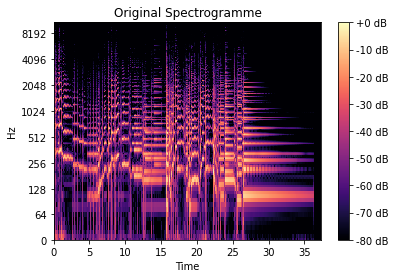

In [ ]:
import librosa
from librosa import display

y, sr = librosa.load(audio_path + '/x_test.wav')
S = np.abs(librosa.stft(y))

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax)
ax.set_title("Original Spectrogramme")
fig.colorbar(img, ax=ax, format="%+2.0f dB")

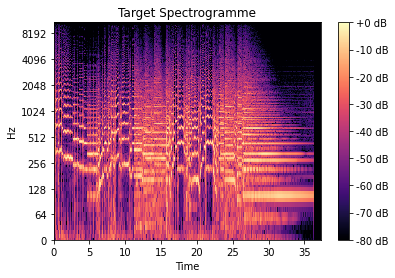

In [ ]:
y, sr = librosa.load(audio_path + '/y_test.wav')
S = np.abs(librosa.stft(y))

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax)
ax.set_title("Target Spectrogramme")
fig.colorbar(img, ax=ax, format="%+2.0f dB")

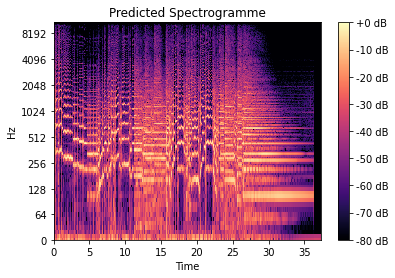

In [ ]:
y, sr = librosa.load(audio_path + '/y_pred_50epochs.wav')
S = np.abs(librosa.stft(y))

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax)
ax.set_title("Predicted Spectrogramme")
fig.colorbar(img, ax=ax, format="%+2.0f dB")